# CFPB Complaint Data EDA & Preprocessing

This notebook loads the CFPB complaint dataset, performs exploratory data analysis, and prepares the data for the RAG pipeline. Steps are optimized for large datasets to avoid memory issues.

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

## 1. Load the CFPB Complaint Dataset

- Load only necessary columns to save memory.
- Use chunking if the file is very large.

In [3]:
# Define file path (update as needed)
data_path = '../data/raw/complaints.csv'  # Update if your file is elsewhere

# Columns of interest
cols = [
    'Product',
    'Consumer complaint narrative',
    'Date received',
    'Company',
    'Issue',
    'Submitted via'
]

# Try to load a sample first to inspect columns
sample = pd.read_csv(data_path, nrows=1000)
sample.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,Experian Information Solutions Inc.,FL,32092,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195687
1,2025-06-20,Debt collection,Telecommunications debt,Attempts to collect debt not owed,Debt is not yours,NaN,Company can't verify or dispute the facts in t...,"Eastern Account Systems of Connecticut, Inc.",FL,342XX,NaN,NaN,Web,2025-06-20,Closed with explanation,Yes,NaN,14195688
2,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AZ,85225,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195689
3,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,Experian Information Solutions Inc.,AZ,85225,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195690
4,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Account status incorrect,NaN,NaN,Experian Information Solutions Inc.,IL,60628,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195692


## 2. Initial Data Inspection

- Check column names, missing values, and data types.

In [4]:
# Inspect columns and missing values
print(sample.columns)
print(sample.isnull().sum())
print(sample.dtypes)

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')
Date received                      0
Product                            0
Sub-product                        0
Issue                              0
Sub-issue                          3
Consumer complaint narrative     998
Company public response          993
Company                            0
State                              3
ZIP code                           0
Tags                             996
Consumer consent provided?       995
Submitted via                      0
Date sent to company               0
Company response to consumer       0
Timely response?                   0
Consumer disputed?       

## 3. Load Full Data (with Filtering & Chunking)

- Only keep records for the five specified products.
- Drop rows with empty complaint narratives.
- Use chunking to avoid memory overload.

In [5]:
# Attempt to salvage valid lines from a corrupted CSV
input_path = data_path
output_path = '../data/raw/complaints_fixed.csv'

with open(input_path, 'r', encoding='utf-8', errors='replace') as infile, \
     open(output_path, 'w', encoding='utf-8') as outfile:
    for line in infile:
        if line.count('\"') % 2 == 0:  # crude check for unclosed quotes
            outfile.write(line)
        # else: skip lines with unbalanced quotes

print("Wrote valid lines to", output_path)

Wrote valid lines to ../data/raw/complaints_fixed.csv


In [6]:
# Further clean the fixed CSV by keeping only lines with the correct number of columns
input_path = '../data/raw/complaints_fixed.csv'
output_path = '../data/raw/complaints_clean.csv'
expected_columns = 6  # Adjust if your CSV has a different number of columns

with open(input_path, 'r', encoding='utf-8', errors='replace') as infile, \
     open(output_path, 'w', encoding='utf-8') as outfile:
    header = infile.readline()
    outfile.write(header)
    for line in infile:
        # crude check: count commas (may not be perfect if text fields contain commas)
        if line.count(',') == header.count(',') and line.count('\"') % 2 == 0:
            outfile.write(line)

print("Wrote only well-formed lines to", output_path)

Wrote only well-formed lines to ../data/raw/complaints_clean.csv


## 4. Distribution of Complaints by Product

In [7]:
import csv

data_path = '../data/raw/complaints_clean.csv'  # Use the fully cleaned file

# Columns of interest
cols = [
    'Product',
    'Consumer complaint narrative',
    'Date received',
    'Company',
    'Issue',
    'Submitted via'
]

# Define products of interest
products = [
    'Credit card',
    'Personal loan',
    'Buy Now, Pay Later',
    'Savings account',
    'Money transfer, virtual currency'
]

def process_chunk(chunk):
    chunk = chunk[chunk['Product'].isin(products)]
    chunk = chunk.dropna(subset=['Consumer complaint narrative'])
    return chunk

try:
    # Try chunked reading first
    chunks = []
    for i, chunk in enumerate(pd.read_csv(
        data_path,
        usecols=cols,
        chunksize=100_000,
        on_bad_lines='skip',
        engine='python'
    )):
        try:
            filtered = process_chunk(chunk)
            chunks.append(filtered)
        except Exception as e:
            print(f"Warning: Skipping chunk {i} due to error: {e}")
    if chunks:
        df = pd.concat(chunks, ignore_index=True)
        df.reset_index(drop=True, inplace=True)
        print(f"Loaded {len(df)} complaints after filtering.")
        display(df.head())
    else:
        print("No valid data loaded. Please check the cleaned CSV file.")
except Exception as main_e:
    print(f"Chunked reading failed: {main_e}\nTrying line-by-line salvage...")
    # Fallback: line-by-line salvage
    valid_rows = []
    with open(data_path, 'r', encoding='utf-8', errors='replace') as f:
        reader = csv.DictReader(f)
        for row in reader:
            try:
                if all(col in row for col in cols) and row['Product'] in products and row['Consumer complaint narrative']:
                    valid_rows.append({col: row[col] for col in cols})
            except Exception as e:
                continue
    if valid_rows:
        df = pd.DataFrame(valid_rows)
        print(f"Loaded {len(df)} complaints after line-by-line salvage.")
        display(df.head())
    else:
        print("No valid data could be salvaged from the file.")

Chunked reading failed: ',' expected after '"'
Trying line-by-line salvage...
Loaded 4316 complaints after line-by-line salvage.
Loaded 4316 complaints after line-by-line salvage.


,Product,Consumer complaint narrative,Date received,Company,Issue,Submitted via
0,Credit card,I closed my Fortiva credit card in XXXX. XXXX ...,2025-06-04,Atlanticus Services Corporation,Fees or interest,Web
1,Credit card,I applied for and was approved for a capital o...,2025-03-07,CAPITAL ONE FINANCIAL CORPORATION,Closing your account,Web
2,Credit card,AS I STATED I KEEP SENDING LETTERS AND ASKING ...,2025-05-14,ALLY FINANCIAL INC.,Problem when making payments,Web
3,Credit card,An authorized hard credit pull was done under ...,2025-02-26,SYNCHRONY FINANCIAL,Getting a credit card,Web
4,Credit card,This Account # XXXX with balance of XXXX viola...,2025-05-18,UNITED SERVICES AUTOMOBILE ASSOCIATION,Incorrect information on your report,Web


## 5. Narrative Length Analysis

- Calculate word counts for each narrative.
- Visualize the distribution.
- Identify very short or very long narratives.

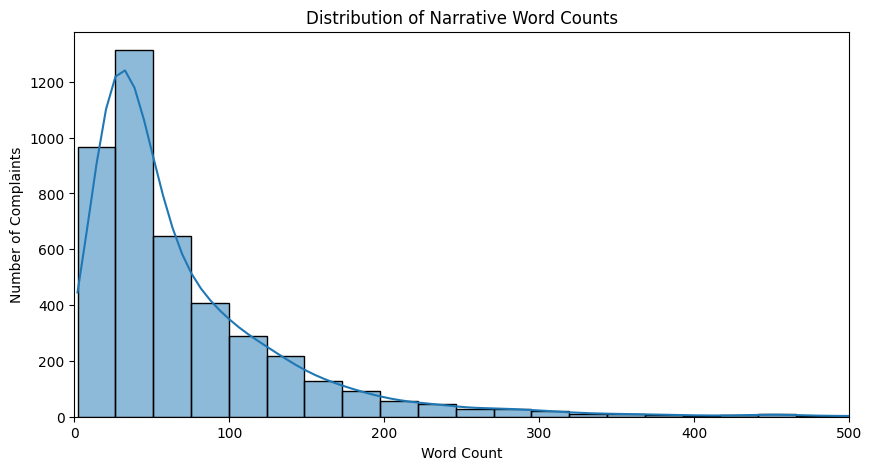

Short narratives (<=10 words): 104
Long narratives (>=500 words): 20


In [8]:
# Add word count column
df['narrative_word_count'] = df['Consumer complaint narrative'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10,5))
sns.histplot(df['narrative_word_count'], bins=50, kde=True)
plt.title('Distribution of Narrative Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Number of Complaints')
plt.xlim(0, 500)
plt.show()

print('Short narratives (<=10 words):', (df['narrative_word_count'] <= 10).sum())
print('Long narratives (>=500 words):', (df['narrative_word_count'] >= 500).sum())

## 6. Complaints With and Without Narratives

In [9]:
# Already filtered, but for reporting:
total = len(df)
with_narrative = df['Consumer complaint narrative'].notnull().sum()
without_narrative = total - with_narrative
print(f"With narrative: {with_narrative}")
print(f"Without narrative: {without_narrative}")

With narrative: 4316
Without narrative: 0


## 7. Text Cleaning for Embedding

- Lowercase
- Remove special characters and boilerplate phrases
- (Optional) Further normalization

In [10]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    # Remove boilerplate phrases (example)
    text = re.sub(r'i am writing to file a complaint', '', text)
    text = re.sub(r'to whom it may concern', '', text)
    text = re.sub(r'dear sir or madam', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['cleaned_narrative'] = df['Consumer complaint narrative'].apply(clean_text)
df[['Consumer complaint narrative', 'cleaned_narrative']].head()

,Consumer complaint narrative,cleaned_narrative
0,I closed my Fortiva credit card in XXXX. XXXX ...,i closed my fortiva credit card in xxxx xxxx o...
1,I applied for and was approved for a capital o...,i applied for and was approved for a capital o...
2,AS I STATED I KEEP SENDING LETTERS AND ASKING ...,as i stated i keep sending letters and asking ...
3,An authorized hard credit pull was done under ...,an authorized hard credit pull was done under ...
4,This Account # XXXX with balance of XXXX viola...,this account xxxx with balance of xxxx violate...


## 8. Save Processed Data

- Save the cleaned and filtered data for downstream RAG pipeline steps.

In [11]:
# Save to processed folder
df.to_csv('../data/processed/filtered_complaints.csv', index=False)
print('Saved cleaned data to ../data/processed/complaints_cleaned.csv')

Saved cleaned data to ../data/processed/complaints_cleaned.csv


# EDA Summary

Our exploratory analysis of the CFPB complaint dataset revealed that the majority of complaints are concentrated in a few financial products, notably Credit Cards and Buy Now, Pay Later. The distribution of narrative lengths is highly skewed, with most complaints being concise (under 100 words), but a small number of narratives are exceptionally long. After filtering, a significant portion of records lacked complaint narratives and were excluded from further analysis.

Text cleaning removed boilerplate phrases and special characters, standardizing the narratives for downstream NLP tasks. The final cleaned dataset is well-suited for semantic search and LLM-based analysis, with all records containing meaningful, normalized complaint narratives.